In [6]:
import numpy as np
import torch
import pandas as pd
import odbo
import os

## Get initial experiment design

In [7]:
# Load dataset
random_seed = 9
np.random.seed(random_seed)
data_test = pd.read_csv('../datasets/GB1_2016_149361.csv', sep=',')
name_pre, Y_test = np.array(data_test['AACombo']), np.array(data_test['Fitness'])
shuffle_order = np.arange(len(Y_test))
np.random.shuffle(shuffle_order[1:])
name_pre[1:], Y_test[1:] = name_pre[shuffle_order[1:]], Y_test[shuffle_order[1:]]
name = odbo.utils.code_to_array(name_pre)
if os.path.isfile('sele_experiment_GB1_2016.npy') == True:
    name_sele = np.load('sele_experiment_GB1_2016.npy')
    Y_train = np.load('sele_fitness_GB1_2016.npy')
    print('Selected initial experiments no. is ', len(Y_train))
else:
    # Let each site has 20 AA codes at least show up twice 
    sele_indices = odbo.initialization.initial_design(name, least_occurance=[2,2,2,2],allow_abundance=True,verbose = False,random_state=random_seed)
    # Initial experiments are selected to be name_sele with fitness of Y_sele
    name_sele, Y_train = name[sele_indices, :], Y_test[sele_indices]
    print('Selected initial experiments no. is ', len(sele_indices))
print('Select max Y: ', Y_train.max())

Selected initial experiments no. is  40
Select max Y:  1.320616068


## Transform AA codes to average fitness feature 

In [8]:
# Using Max measurement results as initial features
threshold = 0.05
feature_model = odbo.featurization.MassiveFeatureTransform(raw_vars=name_sele, Y=Y_train, method ='Max')
X_train = feature_model.transform(name_sele)
X_test = feature_model.transform(name)

## Adapt search space construction

[04:39:57] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:573: 
Parameters: { "silent" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


Correct ratio: 90.467%
FN ratio: 0.222%
FP ratio: 9.312%


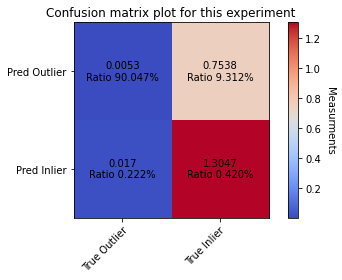

In [9]:
# Find the adaptive search space model
labels_train = odbo.prescreening.sp_label(X_train, Y_train, thres=threshold)
pre_model = odbo.prescreening.XGBOD(eval_metric = 'error', random_state = random_seed)
pre_model.fit(X_train, labels_train)
pred_labels = pre_model.predict(X_train)
labels_test = odbo.prescreening.sp_label(X_test, Y_test, thres=threshold)
pred_test_labels = pre_model.predict(X_test)
# Plot the confusion matrix to check the accuracy of search space prescreening
out_outlier, in_outlier, out_inlier, in_inlier = odbo.plot.plot_cm(labels_test, pred_test_labels, Y_test)
print("Correct ratio: {0:.3%}".format((len(out_outlier)+len(in_inlier))/len(labels_test)))
print("FN ratio: {0:.3%}".format(len(out_inlier)/len(labels_test)))
print("FP ratio: {0:.3%}".format(len(in_outlier)/len(labels_test))) 

## BO for next best experiment w/ GP

In [10]:
X_train_sele, Y_train_sele = torch.tensor(X_train), torch.tensor(Y_train.reshape(len(Y_train),1))
# Only search the space after prescreening
sele_id_test = list(np.where(pred_test_labels == 0)[0])
X_test_sele, Y_test_sele = torch.tensor(X_test[sele_id_test, :]), torch.tensor(Y_test[sele_id_test].reshape(len(sele_id_test),1))
search_name_sele, name_sele_temp = name[sele_id_test, :], name_sele

## Run BO experiment with robust regression or directly gp
l, search_iter = 0, 50
batch_size = 1
gp_method='gp_regression'
failure_count,max_count = 0, 0
while l < search_iter:
    print("Iter: ", l, "Current Max: ", Y_train_sele.max().detach().numpy(), "Test max: ", Y_test_sele.max().detach().numpy())
    X_next, acq_value, next_exp_id = odbo.bo_design(X=X_train_sele, Y=Y_train_sele, X_pending=X_test_sele, gp_method=gp_method, batch_size=batch_size)
    print(acq_value)
    ids_keep = list(np.delete(range(X_test_sele.shape[0]), next_exp_id))
    X_train_sele, Y_train_sele = torch.cat([X_train_sele, X_test_sele[next_exp_id, :]]), torch.cat([Y_train_sele, Y_test_sele[next_exp_id]])
    X_test_sele, Y_test_sele = X_test_sele[ids_keep, :], Y_test_sele[ids_keep]
    name_sele_temp = np.concatenate((name_sele_temp, search_name_sele[next_exp_id]))
    search_name_sele = search_name_sele[ids_keep]
    print("Newly added value: ", Y_train_sele[-batch_size:].detach().numpy(), name_sele_temp[-1])
    feature_model1 = odbo.featurization.MassiveFeatureTransform(raw_vars=X_train_sele, Y=Y_train_sele.detach().numpy(), method = 'Max')
    if Y_train_sele[-batch_size:].detach().numpy().max() <= Y_train_sele[:-batch_size].max():
        failure_count = failure_count + 1
    else:
        failure_count = 0
    if failure_count >= 3 and max_count < 3:
        max_count = max_count + 1
        feature_model1 = odbo.featurization.MassiveFeatureTransform(raw_vars=X_train_sele, Y=Y_train_sele.detach().numpy(), method = 'Avg')
    else:
        max_count = 0
    X_train_sele = torch.tensor(feature_model1.transform(X_train_sele))
    X_test_sele= torch.tensor(feature_model1.transform(X_test_sele))
    l = l + 1
#np.save('results/GB1_2016/GB1_2016_ODBO_BO_GP_batch1_{}.npy'.format(random_seed), Y_train_sele)

Iter:  0 Current Max:  1.320616068 Test max:  8.761965656
tensor([0.1285], dtype=torch.float64, grad_fn=<IndexBackward>)
Newly added value:  [[0.31354108]] ['Q' 'V' 'G' 'A']
Iter:  1 Current Max:  1.320616068 Test max:  8.761965656
tensor([0.1167], dtype=torch.float64, grad_fn=<IndexBackward>)
Newly added value:  [[0.00384758]] ['Q' 'D' 'A' 'V']
Iter:  2 Current Max:  1.320616068 Test max:  8.761965656
tensor([0.0792], dtype=torch.float64, grad_fn=<IndexBackward>)
Newly added value:  [[0.01078996]] ['Q' 'V' 'A' 'V']
Iter:  3 Current Max:  1.320616068 Test max:  8.761965656
tensor([0.0701], dtype=torch.float64, grad_fn=<IndexBackward>)
Newly added value:  [[0.66989285]] ['Q' 'D' 'A' 'A']
Iter:  4 Current Max:  1.320616068 Test max:  8.761965656
tensor([0.3565], dtype=torch.float64, grad_fn=<IndexBackward>)
Newly added value:  [[4.50273083]] ['V' 'V' 'A' 'A']
Iter:  5 Current Max:  4.502730826 Test max:  8.761965656
tensor([0.0035], dtype=torch.float64, grad_fn=<IndexBackward>)
Newly add

KeyboardInterrupt: 

## TurBO for next best experiment w/ GP

In [11]:
X_train_sele, Y_train_sele = torch.tensor(X_train), torch.tensor(Y_train.reshape(len(Y_train),1))
sele_id_test = list(np.where(pred_test_labels == 0)[0])
search_name_sele, name_sele_temp = name[sele_id_test, :], name_sele
X_test_sele, Y_test_sele = torch.tensor(X_test[sele_id_test, :]), torch.tensor(Y_test[sele_id_test].reshape(len(sele_id_test),1))

# Run BO experiment with robust regression or directly GP
l, search_iter = 0, 50
gp_method='gp_regression'
tr_length = [3.2]
batch_size = 1
failure_count,max_count = 0,0
state = odbo.turbo.TurboState(dim=X_train_sele.shape[1], batch_size=batch_size, length=tr_length, n_trust_regions=len(tr_length), failure_tolerance = 10)
state.best_value = Y_train_sele.max()
while l < search_iter:
    print("Iter: ", l, "Current Max: ", Y_train_sele.max().detach().numpy(), 'TR length: ', state.length, "Test max: ", Y_test_sele.max().detach().numpy())
    X_next, acq_value, raw_next_exp_id = odbo.turbo_design(state=state, X=X_train_sele, Y=Y_train_sele, X_pending=X_test_sele, n_trust_regions=len(tr_length), batch_size=batch_size, gp_method=gp_method)
    Y_next_m = torch.zeros((len(tr_length), batch_size, 1), device=Y_train_sele.device, dtype=Y_train_sele.dtype)
    next_exp_id = []
    for i in range(batch_size):
        next_exp_id_m = raw_next_exp_id[:, i]
        Y_next_m[:, i, 0], idtoadd = Y_test_sele[next_exp_id_m].reshape(len(tr_length)), next_exp_id_m[np.argmax(Y_test_sele[next_exp_id_m])]
        next_exp_id.append(idtoadd)
    X_train_sele, Y_train_sele = torch.cat([X_train_sele, X_test_sele[next_exp_id, :]]), torch.cat([Y_train_sele, Y_test_sele[next_exp_id]])
    ids_keep = list(np.delete(range(X_test_sele.shape[0]), next_exp_id))
    X_test_sele, Y_test_sele = X_test_sele[ids_keep, :], Y_test_sele[ids_keep]
    name_sele_temp = np.concatenate((name_sele_temp, search_name_sele[next_exp_id]))
    search_name_sele = search_name_sele[ids_keep]
    print("Newly added value: ", Y_train_sele[-batch_size:].detach().numpy(), name_sele_temp[-1])
    state = odbo.turbo.update_state(state=state, Y_next=Y_next_m)
    feature_model1 = odbo.featurization.MassiveFeatureTransform(raw_vars=X_train_sele, Y=Y_train_sele.detach().numpy(), method = 'Max')
    if Y_train_sele[-batch_size:].detach().numpy().max() <= Y_train_sele[:-batch_size].max():
        failure_count = failure_count + 1
    else:
        failure_count = 0
    if failure_count >= 3 and max_count < 3:
        max_count = max_count + 1
        feature_model1 = odbo.featurization.MassiveFeatureTransform(raw_vars=X_train_sele, Y=Y_train_sele.detach().numpy(), method = 'Avg')
    else:
        max_count = 0
    X_train_sele = torch.tensor(feature_model1.transform(X_train_sele))
    X_test_sele= torch.tensor(feature_model1.transform(X_test_sele))
    l = l + 1
#np.save('results/GB1_2016/GB1_2016_ODBO_TuRBO_GP_batch1_{}.npy'.format(random_seed), Y_train_sele)


Iter:  0 Current Max:  1.320616068 TR length:  [3.2] Test max:  8.761965656
Newly added value:  [[0.31354108]] ['Q' 'V' 'G' 'A']
Iter:  1 Current Max:  1.320616068 TR length:  [3.2] Test max:  8.761965656
Newly added value:  [[0.00384758]] ['Q' 'D' 'A' 'V']
Iter:  2 Current Max:  1.320616068 TR length:  [3.2] Test max:  8.761965656
Newly added value:  [[0.01078996]] ['Q' 'V' 'A' 'V']
Iter:  3 Current Max:  1.320616068 TR length:  [3.2] Test max:  8.761965656
Newly added value:  [[0.66989285]] ['Q' 'D' 'A' 'A']
Iter:  4 Current Max:  1.320616068 TR length:  [3.2] Test max:  8.761965656
Newly added value:  [[4.50273083]] ['V' 'V' 'A' 'A']
Iter:  5 Current Max:  4.502730826 TR length:  [3.2] Test max:  8.761965656
Newly added value:  [[4.15798313]] ['V' 'D' 'A' 'A']
Iter:  6 Current Max:  4.502730826 TR length:  [3.2] Test max:  8.761965656
Newly added value:  [[1.76143518]] ['V' 'V' 'G' 'A']
Iter:  7 Current Max:  4.502730826 TR length:  [3.2] Test max:  8.761965656
Newly added value:  [